In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load the data set
from google.colab import files
uploaded = files.upload()

Saving exchange_rate.csv to exchange_rate.csv


In [3]:
df = pd.read_csv('exchange_rate.csv')

In [4]:
# Ensue the date column is properly sorted and converted to datetime
df = df.sort_values(by='date')
df["date"] = pd.to_datetime(df["date"], errors='coerce')

In [5]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 0 to 7304
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2998 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 177.8 KB


In [6]:
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
365,1991-01-01,0.7645
730,1992-01-01,0.6720
1096,1993-01-01,0.7403
1461,1994-01-01,0.7350


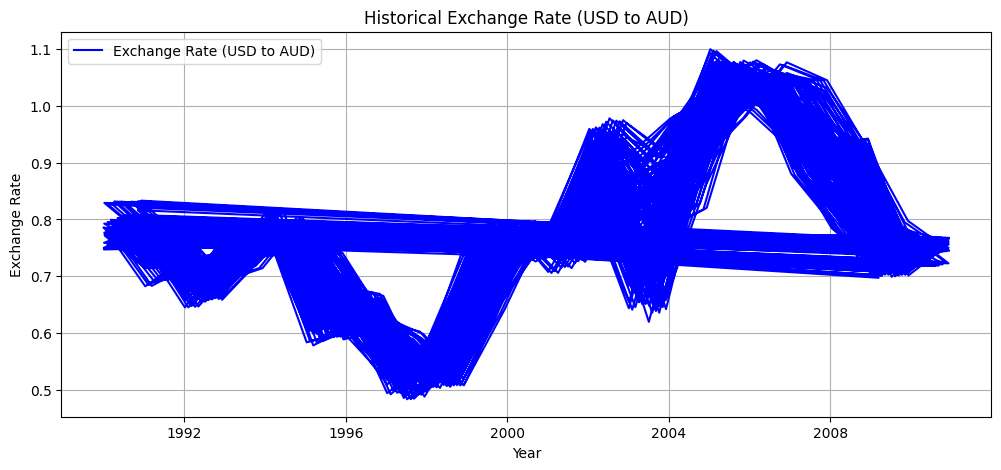

In [7]:
# Step 2: Plot the time series data
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["Ex_rate"], label="Exchange Rate (USD to AUD)", color='blue')
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.title("Historical Exchange Rate (USD to AUD)")
plt.legend()
plt.grid()
plt.show()

In [8]:
# Check for missing values
df.isnull().sum()

,0
date,4590
Ex_rate,0


In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
# Step 3: Perform Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(df["Ex_rate"])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Statistic: -14.438089479961612
p-value: 7.437614382254163e-27


In [11]:
# Apply test after differencing to make the series stationary
df["Ex_rate_diff"] = df["Ex_rate"].diff()

In [12]:
# ADF test after differencing
adf_test_diff = adfuller(df["Ex_rate_diff"].dropna())
print("ADF Statistic (Differenced):", adf_test_diff[0])
print("p-value:", adf_test_diff[1])

ADF Statistic (Differenced): -28.6148661635049
p-value: 0.0


In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

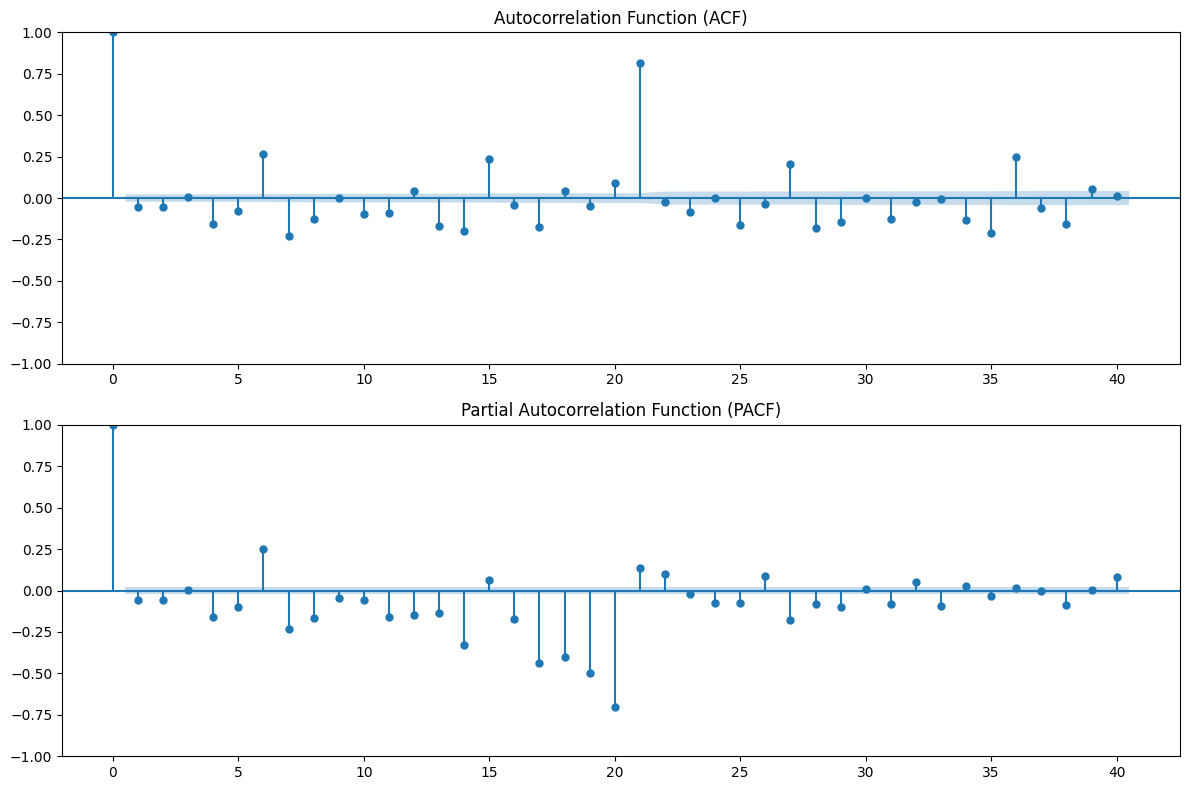

In [14]:
# Plot ACF and PACF
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df["Ex_rate_diff"].dropna(), ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(df["Ex_rate_diff"].dropna(), ax= ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

In [15]:
from statsmodels.tsa.arima.model import ARIMA

In [16]:
# Step 4: Fit ARIMA model (1,1,1)
arima_model = ARIMA(df["Ex_rate"], order=(1,1,1))
arima_fit = arima_model.fit()
arima_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7260.780
Date:                Mon, 24 Feb 2025   AIC                         -14515.560
Time:                        11:36:37   BIC                         -14494.758
Sample:                             0   HQIC                        -14508.421
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7336      0.009     79.748      0.000       0.716       0.752
ma.L1         -1.0000      0.329     -3.042      0.002      -1.644      -0.356
sigma2         0.0086      0.003      3.036      0.002       0.003       0.014
===================================================================================
Ljung-Box (L1) (Q):                  31.73   Jarque-Bera (JB):                45.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.15
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# Forecast the next 30 days
forecast_steps = 30
forecast = arima_fit.forecast(steps=forecast_steps)
if not df["date"].empty and not pd.isnull(df["date"].iloc[-1]):
    forecast_dates = pd.date_range(start=df["date"].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
else:
    forecast_dates = pd.date_range(start=pd.Timestamp.today(), periods=forecast_steps, freq='D')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


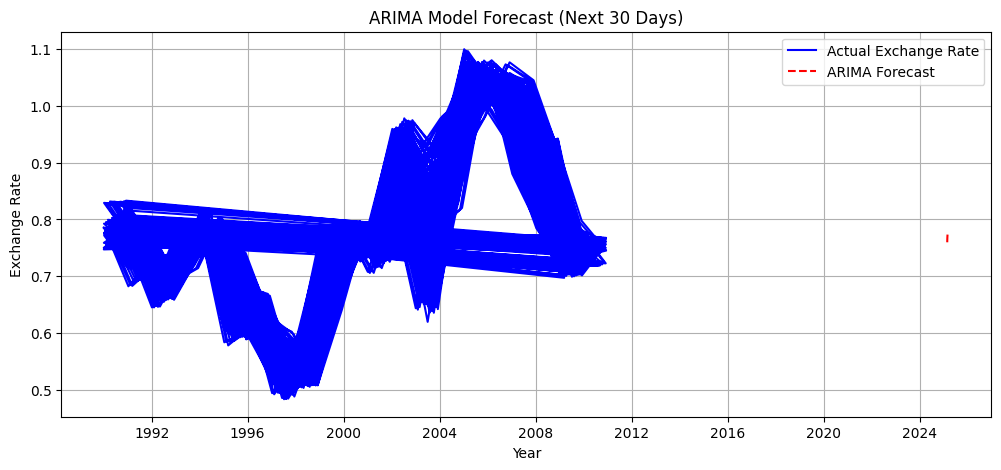

In [18]:
# Plot ARIMA forecast
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["Ex_rate"], label="Actual Exchange Rate", color='blue')
plt.plot(forecast_dates, forecast, label="ARIMA Forecast", color='red', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.title("ARIMA Model Forecast (Next 30 Days)")
plt.legend()
plt.grid()
plt.show()

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [23]:
# Fit Exponential Smoothing model
exp_smooth_model = ExponentialSmoothing(df["Ex_rate"], trend="add", seasonal=None).fit()
exp_forecast = exp_smooth_model.forecast(steps=forecast_steps)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


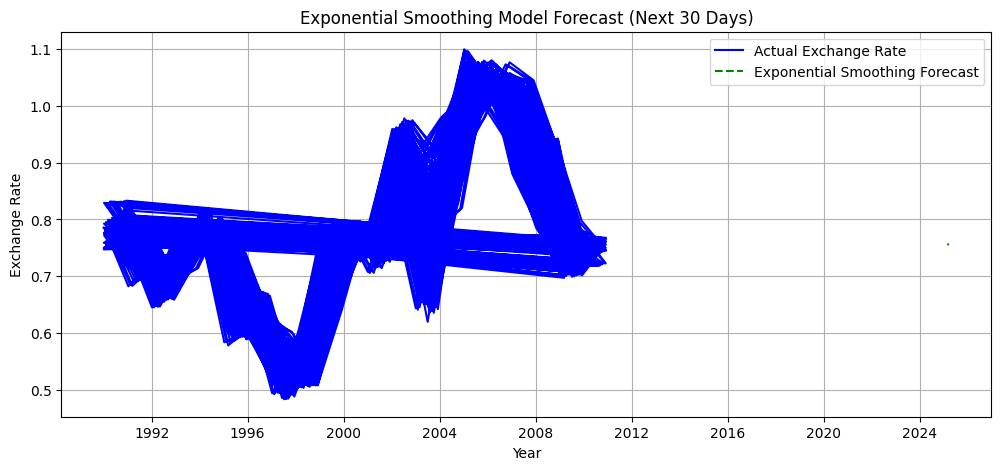

In [24]:
# Plot Exponential Smoothing forecast
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["Ex_rate"], label="Actual Exchange Rate", color='blue')
plt.plot(forecast_dates, exp_forecast, label="Exponential Smoothing Forecast", color='green', linestyle='dashed')
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.title("Exponential Smoothing Model Forecast (Next 30 Days)")
plt.legend()
plt.grid()
plt.show()

In [25]:
# Computer error metrics
actual_values = df["Ex_rate"].iloc[-forecast_steps:].values

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [27]:
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

mae_arima, rmse_arima, mape_arima = compute_metrics(actual_values, forecast)
mae_exp, rmse_exp, mape_exp = compute_metrics(actual_values, exp_forecast)


In [28]:
# Compare models
error_df = pd.DataFrame({
    "Model": ["ARIMA(1,1,1)", "Exponential Smoothing"],
    "MAE": [mae_arima, mae_exp],
    "RMSE": [rmse_arima, rmse_exp],
    "MAPE (%)": [mape_arima, mape_exp]
})
print(error_df)

                   Model       MAE      RMSE   MAPE (%)
0           ARIMA(1,1,1)  0.114081  0.145297  14.034086
1  Exponential Smoothing  0.115751  0.150900  13.903080
